# Redução da dimensionalidade

### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## PCA

### Usando a decomposição SVD

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

#### Primeiro componente

In [5]:
Vt.T[:, 0]

array([0.93636116, 0.29854881, 0.18465208])

####  Calculando a razão de variância explicada

In [6]:
explained_variance_ratio = np.square(s) / np.square(s).sum()
explained_variance_ratio[:2]

array([0.84248607, 0.14631839])

#### Perda da variação com a redução

In [7]:
1 - explained_variance_ratio[:2].sum()

0.011195535570688864

#### Reduzindo para d Dimensões

In [8]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

### Usando Scikit-Learn

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [10]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [11]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

#### Primeiro componente

In [12]:
pca.components_.T[:, 0]

array([-0.93636116, -0.29854881, -0.18465208])

#### Variância explicada

In [13]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

#### Perda da variação com a redução

In [14]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

#### Recuperando os pontos 3D projetados no plano

In [15]:
X3D_inv = pca.inverse_transform(X2D)

#### Erro de reconstrução

In [16]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

### Escolhendo o número certo de dimensões

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)
X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Calculando o número mínimo de dimensões

In [18]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

#### Usando o n_components

In [19]:
pca_1 = PCA(n_components=0.95)
X_reduced = pca_1.fit_transform(X_train)
pca_1.n_components_

154

#### Método do cotovelo

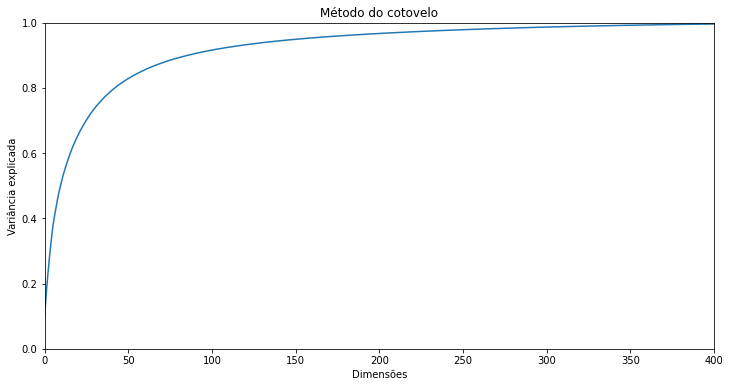

In [20]:
pca_2 = PCA()
pca_2.fit(X_train)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.cumsum(pca_2.explained_variance_ratio_))
ax.set(xlabel='Dimensões', ylabel='Variância explicada', title='Método do cotovelo', ylim=(0, 1), xlim=(0, 400))
plt.show()

### PCA para compressão

In [21]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

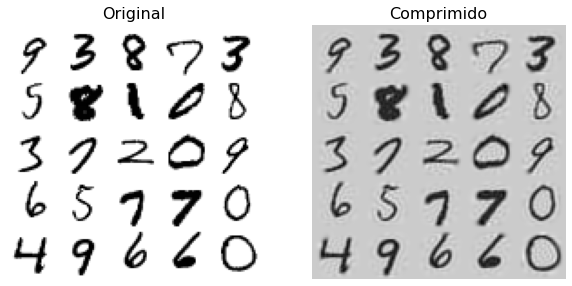

In [22]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

    
plt.figure(figsize=(10, 7))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original', fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title('Comprimido', fontsize=16)
plt.show()

### PCA Incremental (IPCA)

In [23]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

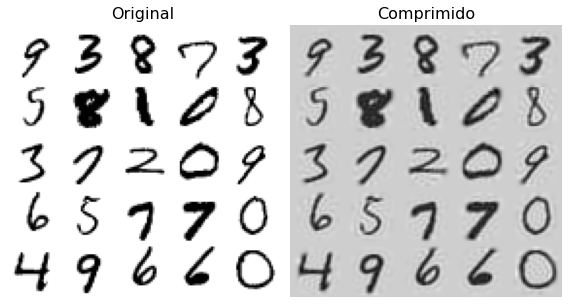

In [24]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

plt.figure(figsize=(8, 5))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original', fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title('Comprimido', fontsize=16)
plt.tight_layout()
plt.show()

### PCA Randomizado

In [25]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

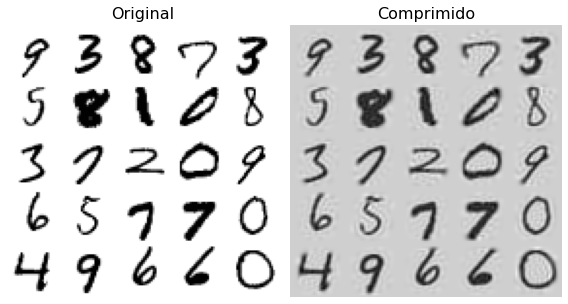

In [26]:
X_recovered_rnd = rnd_pca.inverse_transform(X_reduced)

plt.figure(figsize=(8, 5))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original', fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_rnd[::2100])
plt.title('Comprimido', fontsize=16)
plt.tight_layout()
plt.show()

### Kernel PCA

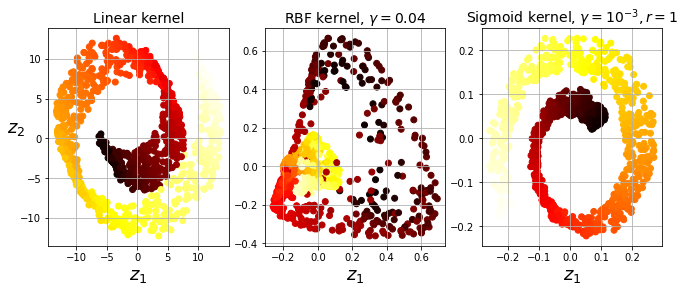

In [27]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in (
    (131, lin_pca, 'Linear kernel'), 
    (132, rbf_pca, 'RBF kernel, $\gamma=0.04$'), 
    (133, sig_pca, 'Sigmoid kernel, $\gamma=10^{-3}, r=1$')):
    
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel('$z_1$', fontsize=18)
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    plt.grid(True)
plt.show()

#### Selecionando um kernel e ajustando os hiperparâmetros

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ('kpca', KernelPCA(n_components=2)),
        ('log_reg', LogisticRegression(solver='liblinear'))
    ])

param_grid = [{
        'kpca__gamma': np.linspace(0.03, 0.05, 10),
        'kpca__kernel': ['rbf', 'sigmoid']
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [29]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [30]:
from sklearn.metrics import mean_squared_error

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X, X_preimage)

32.786308795766125